In [1]:
import os
import tarfile
import urllib.request
from gettext import install
from statistics import LinearRegression

import pandas
from pkg_resources import non_empty_lines

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
CURRENT_DIR = os.getcwd()  # Get the current working directory
HOUSING_PATH = os.path.join(CURRENT_DIR, "datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)  # Create the directories if they do not exist
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)  # Download the file
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)  # Extract the contents
    housing_tgz.close()

# Call the function to fetch the data
fetch_housing_data()


C:\Users\aksel\AppData\Local\Temp\ipykernel_39232\359773791.py:8: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import non_empty_lines


In [2]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)


In [3]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Using matplotlib backend: module://matplotlib_inline.backend_inline


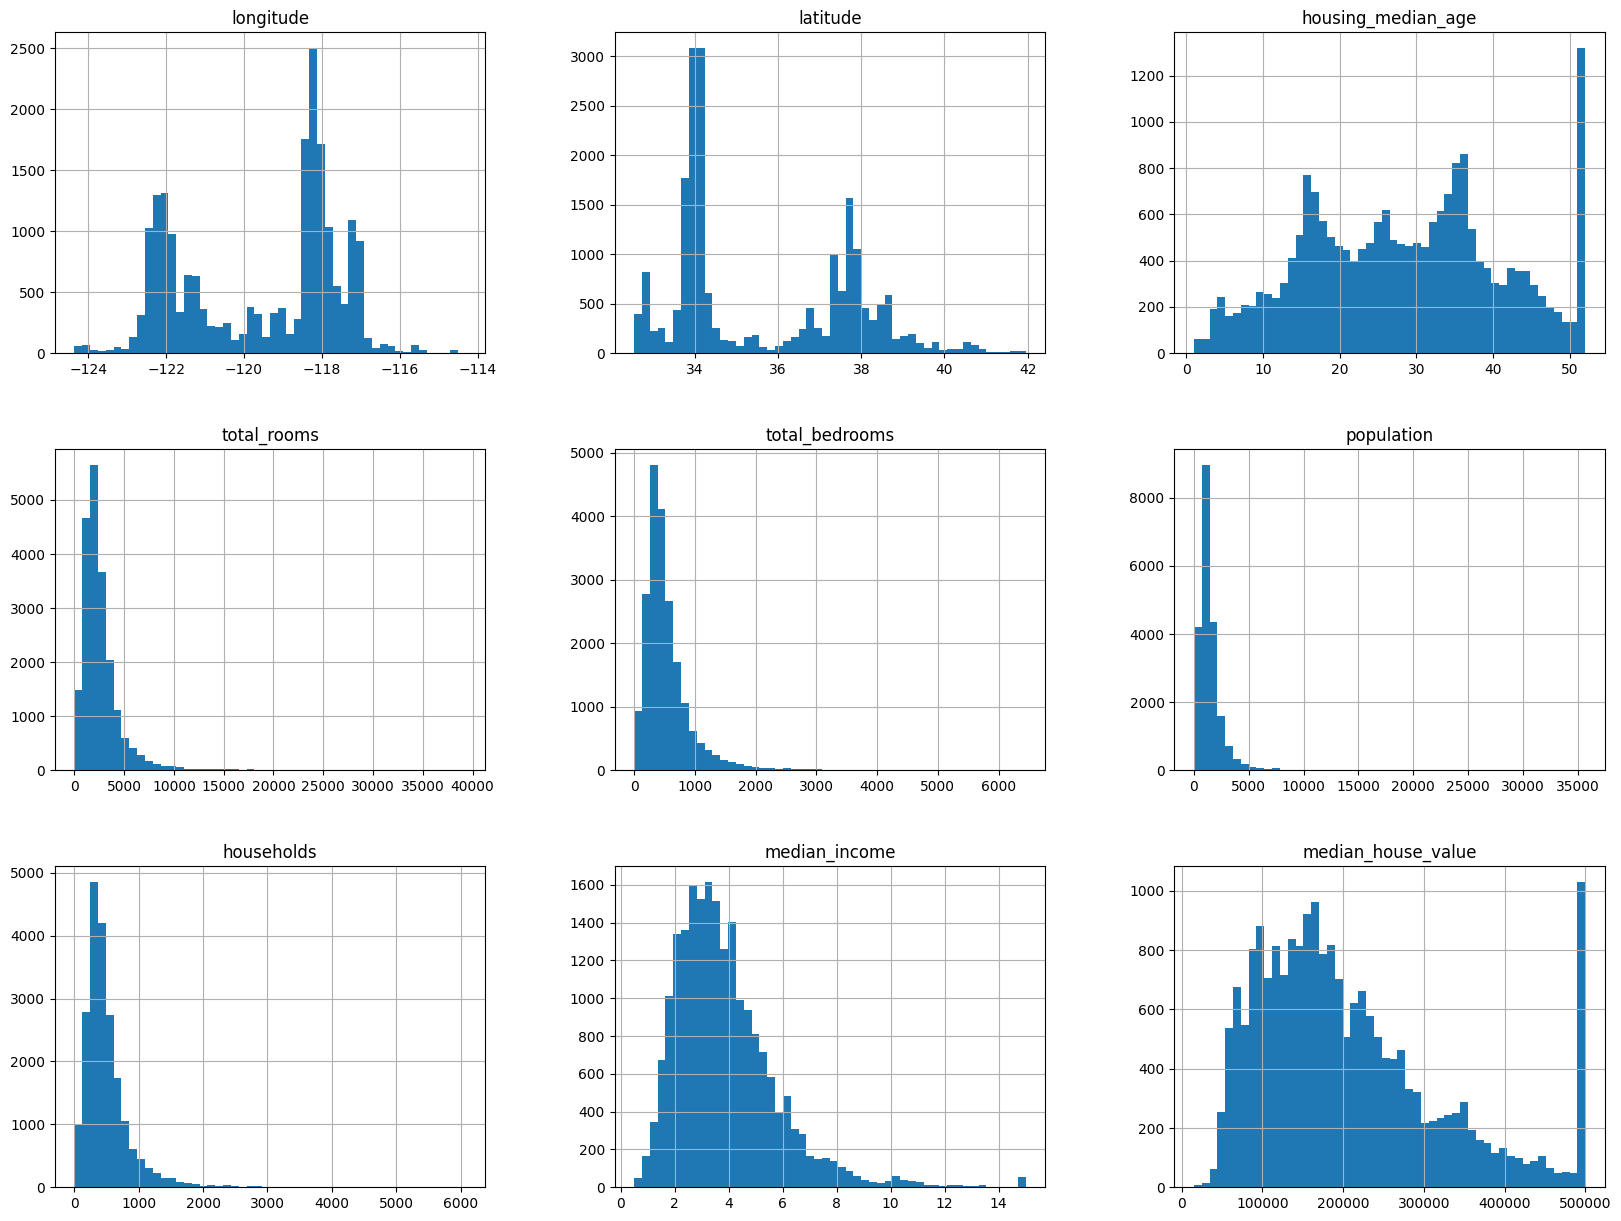

In [7]:
%matplotlib
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [8]:
import numpy as np
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(data.index)
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [9]:
train_set, test_set = split_train_test(housing, test_ratio=0.2)
len(train_set), len(test_set)

(16512, 4128)

In [10]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio *2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids=data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio)) 
    return data.loc[~in_test_set], data.loc[in_test_set]

In [11]:
housing_with_id=housing.reset_index()
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

<Axes: >

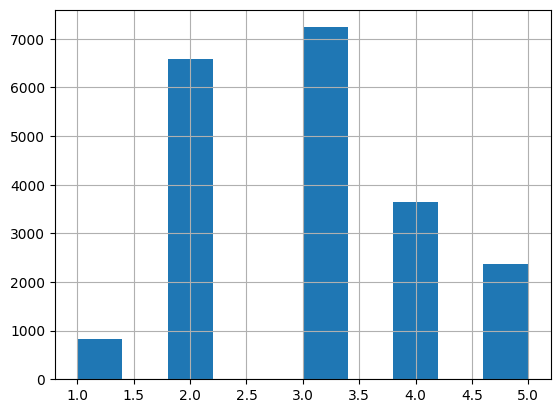

In [12]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0.,1.5,3.0,4.5,6., np.inf], labels=[1,2,3,4,5])
housing["income_cat"].hist()

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [14]:
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [15]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [16]:
housing = strat_train_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

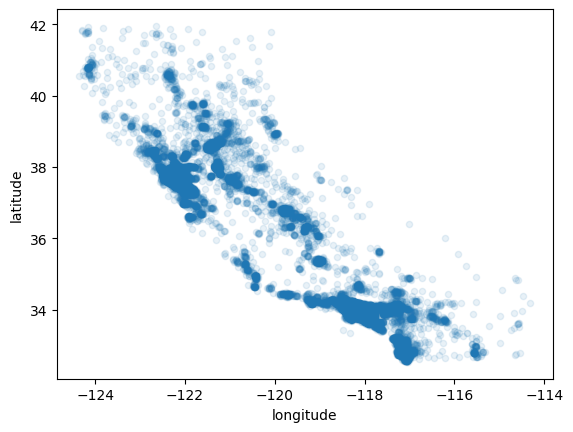

In [17]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

<Axes: xlabel='longitude', ylabel='latitude'>

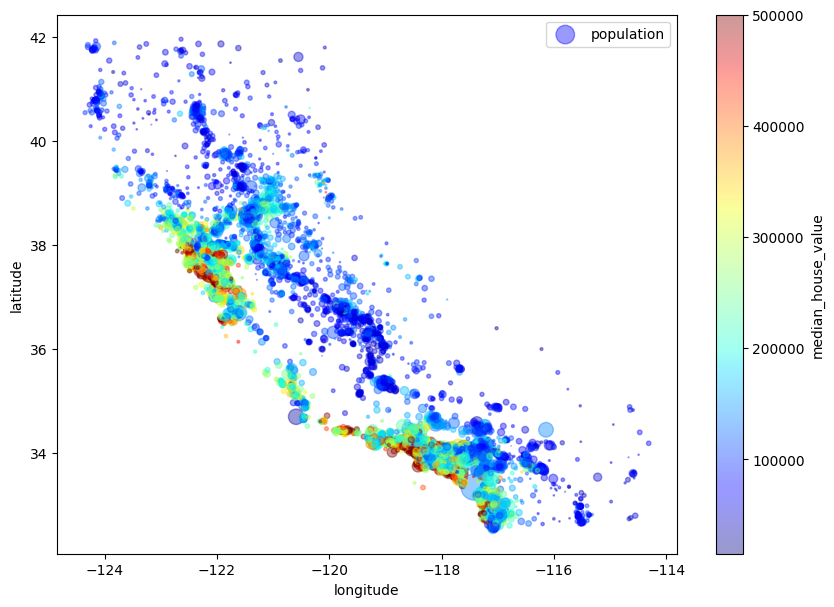

In [18]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, s=housing["population"]/100, label='population', figsize=(10,7),c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True )

In [19]:
# Select only numeric columns
corr_matrix = housing.select_dtypes(include=[float, int]).corr()
print(corr_matrix)


                    longitude  latitude  housing_median_age  total_rooms  \
longitude            1.000000 -0.924478           -0.105823     0.048909   
latitude            -0.924478  1.000000            0.005737    -0.039245   
housing_median_age  -0.105823  0.005737            1.000000    -0.364535   
total_rooms          0.048909 -0.039245           -0.364535     1.000000   
total_bedrooms       0.076686 -0.072550           -0.325101     0.929391   
population           0.108071 -0.115290           -0.298737     0.855103   
households           0.063146 -0.077765           -0.306473     0.918396   
median_income       -0.019615 -0.075146           -0.111315     0.200133   
median_house_value  -0.047466 -0.142673            0.114146     0.135140   

                    total_bedrooms  population  households  median_income  \
longitude                 0.076686    0.108071    0.063146      -0.019615   
latitude                 -0.072550   -0.115290   -0.077765      -0.075146   
housing_

In [20]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

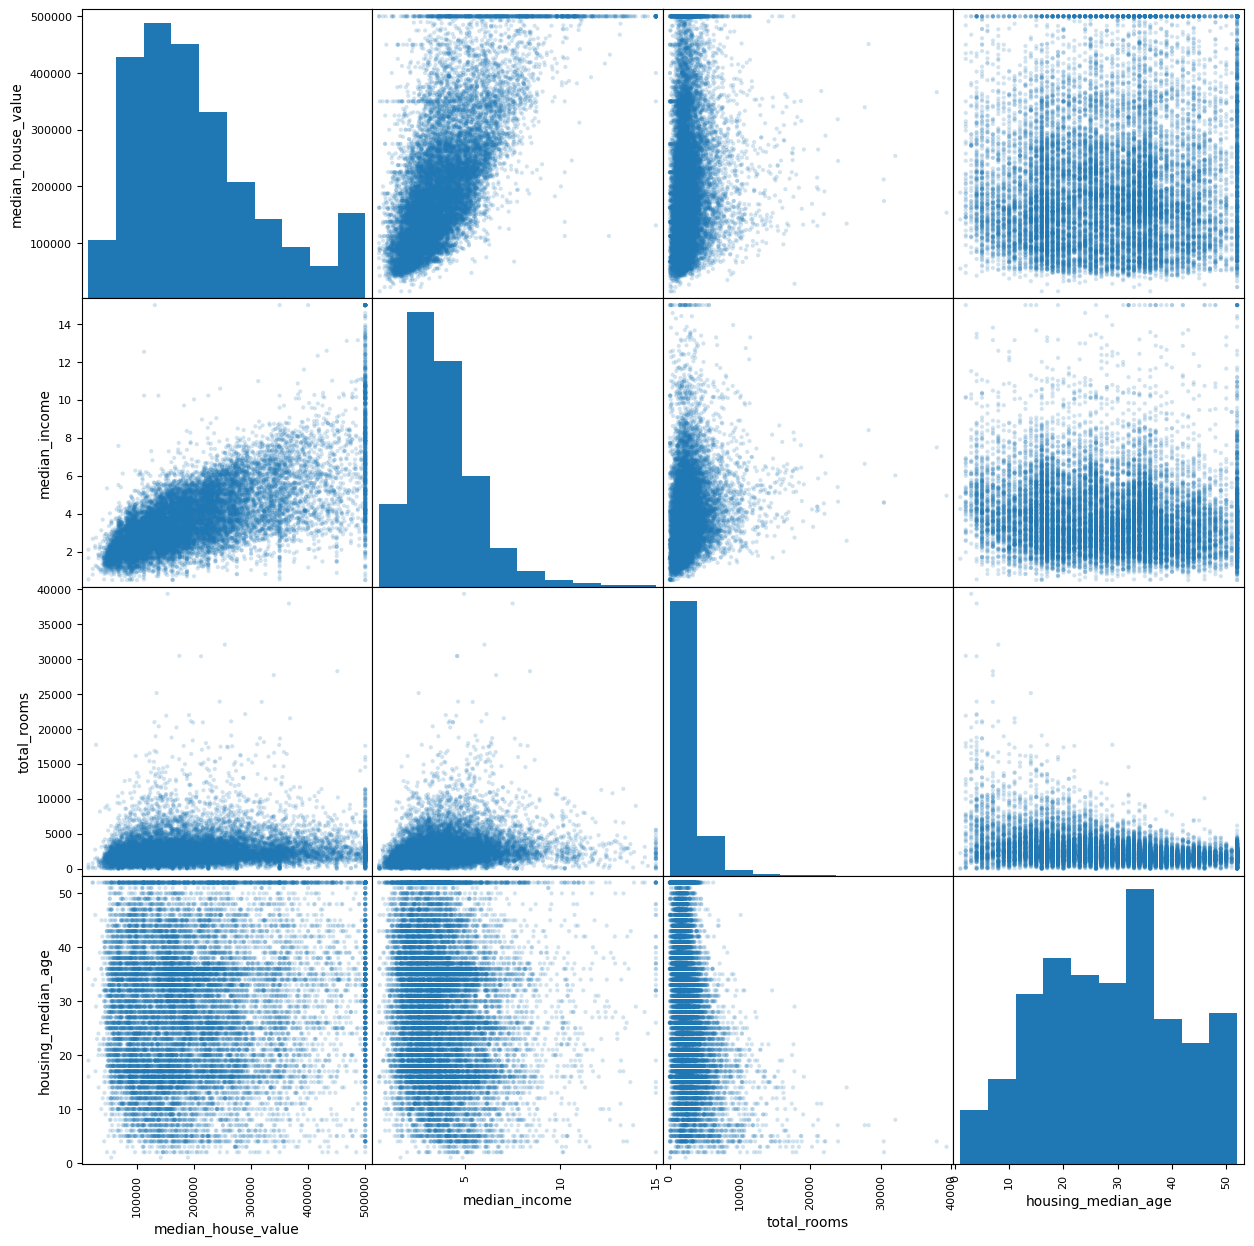

In [21]:
from pandas.plotting import scatter_matrix
atributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[atributes], alpha=0.2, figsize=(15,15))

<Axes: xlabel='median_income', ylabel='median_house_value'>

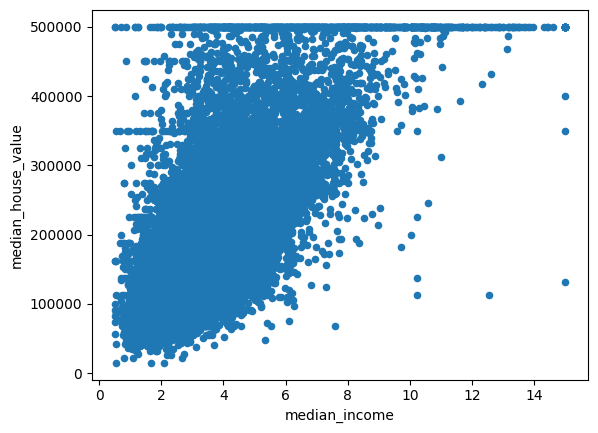

In [22]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",)

In [23]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"] 
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [24]:
# Select only numeric columns
corr_matrix = housing.select_dtypes(include=[float, int]).corr()
print(corr_matrix)


                          longitude  latitude  housing_median_age  \
longitude                  1.000000 -0.924478           -0.105823   
latitude                  -0.924478  1.000000            0.005737   
housing_median_age        -0.105823  0.005737            1.000000   
total_rooms                0.048909 -0.039245           -0.364535   
total_bedrooms             0.076686 -0.072550           -0.325101   
population                 0.108071 -0.115290           -0.298737   
households                 0.063146 -0.077765           -0.306473   
median_income             -0.019615 -0.075146           -0.111315   
median_house_value        -0.047466 -0.142673            0.114146   
rooms_per_household       -0.028374  0.107665           -0.147184   
bedrooms_per_room          0.095645 -0.116955            0.136768   
population_per_household  -0.000415  0.005426            0.015031   

                          total_rooms  total_bedrooms  population  households  \
longitude            

In [25]:
print(corr_matrix['median_house_value'].sort_values(ascending=False))

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64


In [26]:
housing = strat_train_set.drop("median_house_value", axis=1) 
housing_labels = strat_train_set["median_house_value"].copy()

print(housing_labels.sort_values(ascending=False))

18077    500001.0
4861     500001.0
14491    500001.0
5275     500001.0
17279    500001.0
           ...   
1825      22500.0
16186     22500.0
19802     14999.0
2521      14999.0
2799      14999.0
Name: median_house_value, Length: 16512, dtype: float64


In [27]:
housing.drop('total_bedrooms', axis=1)

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,2237.0,706.0,2.1736,INLAND
15502,-117.23,33.09,7.0,5320.0,2015.0,768.0,6.3373,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,667.0,300.0,2.8750,INLAND
14053,-117.13,32.75,24.0,1877.0,898.0,483.0,2.2264,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,1837.0,580.0,4.4964,<1H OCEAN
...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,2026.0,1001.0,5.0900,<1H OCEAN
12661,-121.42,38.51,15.0,7901.0,4769.0,1418.0,2.8139,INLAND
19263,-122.72,38.44,48.0,707.0,458.0,172.0,3.1797,<1H OCEAN
19140,-122.70,38.31,14.0,3155.0,1208.0,501.0,4.1964,<1H OCEAN


In [28]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
housing_num=housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)

imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [29]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [30]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [31]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [32]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded=ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [33]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [34]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [35]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN


In [36]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix,bedrooms_ix,population_ix, households_ix = 3,4,5,6

class CombinedAttrubutesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix]/X[:, households_ix]
        population_per_household = X[:, population_ix]/X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix]/X[:, bedrooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        

attr_adder = CombinedAttrubutesAdder(add_bedrooms_per_room=False)
housing_extra_attribs=attr_adder.transform(housing.values)
    

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attrribs_adder', CombinedAttrubutesAdder()),
    ('std_scaler', StandardScaler()),
])
housing_num_tr=num_pipeline.fit_transform(housing_num)


In [38]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([('num', num_pipeline, num_attribs),('cat', OneHotEncoder(), cat_attribs)])

housing_prepared = full_pipeline.fit_transform(housing)

In [39]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [40]:
some_data=housing.iloc[:5]
some_labels=housing_labels.iloc[:5]
some_data_prepared=full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [ 88308.5135735  304174.12243205 154135.1578518  183826.73869117
 247307.37672157]
Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [41]:
from sklearn.metrics import mean_squared_error

housing_predictions=lin_reg.predict(housing_prepared)
lin_mse=mean_squared_error(housing_labels, housing_predictions)
lin_rmse=np.sqrt(lin_mse)
print(lin_rmse)

68911.35422344579


In [42]:
from sklearn.tree import DecisionTreeRegressor 
tree_reg = DecisionTreeRegressor() 
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared) 
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse) 
print(tree_rmse)

0.0


In [43]:
from sklearn.model_selection import cross_val_score 
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10) 
tree_rmse_scores = np.sqrt(-scores)

In [44]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean()) 
    print("Standard deviation:", scores.std()) 
display_scores(tree_rmse_scores)

Scores: [70833.76282344 67826.10314233 70067.46295047 71228.99956706
 67532.83345323 74627.2495196  71831.51139887 71829.93617309
 68262.93318515 72614.22461717]
Mean: 70665.5016830417
Standard deviation: 2157.778372169192


In [45]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [72327.16076767 64517.26490514 68064.68293242 69115.0013636
 67146.11690224 73027.74105799 70586.20149172 69341.53755437
 66928.91520262 70506.05866694]
Mean: 69156.06808447083
Standard deviation: 2462.909908120938


In [46]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared) 
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse) 
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

Scores: [51910.91379337 49171.03155829 45931.64490547 52025.07545056
 47862.30090837 51772.90735497 52505.87021375 50353.71996558
 48684.70700337 53883.91962693]
Mean: 50410.209078066415
Standard deviation: 2328.9653852027677


In [47]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge()
ridge_reg.fit(housing_prepared, housing_labels)
housing_predictions = ridge_reg.predict(housing_prepared)
ridge_mse = mean_squared_error(housing_labels, housing_predictions)
ridge_rmse = np.sqrt(ridge_mse)
ridge_scores = cross_val_score(ridge_reg, housing_prepared, housing_labels,scoring="neg_mean_squared_error", cv=10)
rider_rmse_scores = np.sqrt(-ridge_scores)
display_scores(rider_rmse_scores)


Scores: [72298.93208167 64563.19988857 68057.75963363 69116.93605632
 67144.72867743 73026.94454384 70584.34310916 69341.6448684
 66930.32998126 70507.02300032]
Mean: 69157.18418406045
Standard deviation: 2450.7631675351554


In [48]:
from sklearn.ensemble import GradientBoostingRegressor
gbm_reg = GradientBoostingRegressor()   
gbm_reg.fit(housing_prepared, housing_labels)
housing_predictions = gbm_reg.predict(housing_prepared)
gbm_mse = mean_squared_error(housing_labels, housing_predictions)
gbm_rmse = np.sqrt(gbm_mse)
gbm_scores=cross_val_score(gbm_reg, housing_prepared, housing_labels,scoring="neg_mean_squared_error", cv=10)
gbm_rmse_scores = np.sqrt(-gbm_scores)
display_scores(gbm_rmse_scores)

Scores: [54403.4685783  51875.58217231 49743.1715579  56060.80603997
 51054.01200768 52681.5793349  54545.57363966 53659.98554445
 50644.41663105 55691.1329128 ]
Mean: 53035.97284190221
Standard deviation: 2066.4020254227275


In [49]:
from sklearn.svm import SVR

svr_reg = SVR(kernel='rbf')
svr_reg.fit(housing_prepared, housing_labels)
housing_predictions = svr_reg.predict(housing_prepared)
svr_mse = mean_squared_error(housing_labels, housing_predictions)
svr_rmse = np.sqrt(svr_mse)
svr_scores=cross_val_score(svr_reg, housing_prepared, housing_labels,scoring="neg_mean_squared_error", cv=10)
svr_rmse_scores = np.sqrt(-svr_scores)  
display_scores(svr_rmse_scores)


Scores: [116729.51217955 120111.99469339 113930.22058823 120387.59422605
 114685.2318126  122781.51737944 119839.21663582 118277.12950451
 120233.34964982 118830.00232881]
Mean: 118580.57689982241
Standard deviation: 2606.8092733348653


In [50]:
from sklearn.model_selection import GridSearchCV
param_grid = [{'n_estimators': [5, 10, 20, 50], 'max_features': [4,6,8]}, {'bootstrap': [False], 'n_estimators': [5, 10], 'max_features': [2,3,4]}]
forest_reg = RandomForestRegressor()
grid_search=GridSearchCV(forest_reg, param_grid, scoring="neg_mean_squared_error", return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)
print(grid_search.best_params_)

C:\Users\aksel\OneDrive\Pulpit\Matematyka 3\Pandas_Nauka\.venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'max_features': 6, 'n_estimators': 50}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

param_grid={'kernel':['linear', 'rbf'], 'C':reciprocal(20,200000), 'gamma':expon(scale=1.0)}
svm_reg = SVR()
rnd_search=RandomizedSearchCV(svm_reg, param_distributions=param_grid, n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=42, verbose=2)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END C=629.7823295913721, gamma=3.010121430917521, kernel=linear; total time=   3.7s
[CV] END C=629.7823295913721, gamma=3.010121430917521, kernel=linear; total time=   3.7s
[CV] END C=629.7823295913721, gamma=3.010121430917521, kernel=linear; total time=   3.7s
[CV] END C=629.7823295913721, gamma=3.010121430917521, kernel=linear; total time=   3.7s
[CV] END C=629.7823295913721, gamma=3.010121430917521, kernel=linear; total time=   3.7s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=   8.5s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=   8.4s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=   8.6s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=   8.5s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=   8.5s
[CV] END C=84.14107900575871, gamma=0.059838768608680676, 